<a href="https://colab.research.google.com/github/austin-hwang/nothingbutnet/blob/master/NothingButNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NothingButNET - Quantifying Team Morale by Encoding Game State
=====

We are team **SPACEJAM**, and we wanted to see if we could model "team morale" from the wealth of data we have been given.

**Team morale** is roughly the "confidence" and "cleanliness of play" of the team. One can think of it as momentum. A team with high morale makes few mistakes and glides to victory, while a team with low morale is sloppy and suffers frustrating defeat. As spectators, we can often sense these from watching the game: for example, when a player makes a stunning buzzer-beating 3-pointer at half-time to tie the game, we perceive the morale of the underdog to surge as they see a chance for victory.

Since we as humans can observe and sense these changes in morale, we believe that we can train a deep neural network to capture this property of the game as some part of the "hidden underlying state" of the game. Since deep neural networks essentially learn to create an internal representation, or "encoding" of its input, we believe that we can expose this morale quantification by examining the behavior of the network in different playouts of the game.

This notebook will walk through the preparation and design of the network, before examining an example. Then, we will suggest venues for future work.

Slideshow link: https://docs.google.com/presentation/d/1j324HAPboJpoxIhp93ZeVZddFrDtWACOLtsnDk7Qi6M/edit?usp=sharing

Preparation
-----

We authenticate with Google services and setup our imports.

In [0]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [0]:
from google.cloud import bigquery

client = bigquery.Client(project='stardust-hackathon')

In [0]:
# BigQuery DB prefix
bqdb = "stardust-hackathon.ncaa_mbb"

We use Keras to implement our model.

In [0]:
import keras
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Dense, LSTM

In [0]:
import numpy as np
import random

Data Acqisition
-----
We retreive a list of valid game IDs, which will help us find training examples:

In [0]:
games = client.query(f"SELECT DISTINCT game_id from `{bqdb}.d1_tm_game_stats` AS t").to_dataframe()['game_id'].tolist()

In [0]:
len(games)

27378

 We then set up a helper function to process the play-by-play for a given game into a quantified vector which can be fed into our model.
 
 Note the fields we use: We use the elapsed time, the current point state, along with the event type and its metadata.

In [0]:
# Given a BigQuery `client` and a `game_id` string,
# Return a ordered timeseries of event vectors for that game
# Vector format: [elapsed_time_sec, home_pts, away_pts] + event type one-hot vector (like [is_3PTR, is_FOUL, is_PASS ...])
def get_game_timeseries(client, game_id):
  df = client.query(f"SELECT elapsed_time_sec, home_pts, away_pts, event_type, shot_made, shot_type, rebound_type, foul_type FROM `stardust-hackathon.ncaa_mbb.pbp` WHERE game_id = '{game_id}' ORDER BY elapsed_time_sec ASC").to_dataframe()
  #print(df)
  event_type = {'miss': 0,'steal': 1,'assist': 2,'rebound': 3,'block': 4,'turnover': 5,'sub': 6,'foul': 7,'good': 8,'timeout': 9, 'tv_timeout': 10, 'deadball': 11, 'for': 12, 'def pts': 13}
  shot_type = {'3ptr': 0, 'ft': 1, 'layup': 2, 'dunk': 3, 'jumper': 4, 'tipin': 5}
  rebound_type = {'def': 0, 'off': 1, 'deadb': 2}
  all_vectors = []

  df.fillna(0)

  df['home_pts'] = df['home_pts'].replace(0, method='ffill')
  df['away_pts'] = df['away_pts'].replace(0, method='ffill')
 
  
  for i in range(len(df['elapsed_time_sec'])):
    vector = []
    for row in df:
      val = df[f'{row}'][i]
      if row == 'shot_made':
        if val:
          vector.append(1)
        else:
          vector.append(0)
      elif row == 'event_type':
          temp = [0 for _ in range(14)]
          if val:
            temp[event_type[val.lower()]] = 1
          vector.extend(temp)
      elif row == 'shot_type':
          temp = [0 for _ in range(6)]
          if val:
            temp[shot_type[val.lower()]] = 1
          vector.extend(temp)
      elif row == 'rebound_type':
          temp = [0 for _ in range(3)]
          if val:
            temp[rebound_type[val.lower()]] = 1
          vector.extend(temp)
      elif row == 'foul_type':
          if val:
            if val.lower() == 'tech':
              vector.append(1)
            else:
              vector.append(0)
          else:
              vector.append(0)
      else:
        vector.append(float(val))
        
#     print(vector)
    all_vectors.append(vector)
  return all_vectors


In [0]:
# Example output
print(get_game_timeseries(client, "2743-655-2018-02-07")[-1])

[2389.0, 68.0, 86.0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]


Model
-----

We design an LSTM model which will learn the underlying game state in its encoding layer.

The architecture is as follows:

```
input -> [LSTM] -> (here is the encoding) -> [Fully-Connected Layers] -> Score Ratio after 1 min
                                                 -> [Fully-Connected Layers] -> Score Ratio after 5 min
                                                 -> [Fully-Connected Layers] -> Score Ratio after 10 min
```

In [0]:
def DenseStack(x, output_size, name, sizes=[]):
  for size in sizes:
    x = Dense(size, activation='relu')(x)
  return Dense(output_size, activation='softmax', name=name)(x)
  

def DeepPredictor(input_shape, encoding_size):
  
  the_input = Input(input_shape)  
  encoding = LSTM(units=encoding_size)(the_input)
  
  after_one = DenseStack(encoding, 2, sizes=[64, 128, 64, 32], name='after_one')
  after_five = DenseStack(encoding, 2, sizes=[64, 128, 64, 32], name='after_five')
  after_ten = DenseStack(encoding, 2, sizes=[64, 128, 64, 32], name='after_ten')
  
  model = Model(inputs=the_input, outputs=[after_one, after_five, after_ten])
  model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(lr=0.00001), metrics=['accuracy'])
  
  return model

We build the model:

In [0]:
model = DeepPredictor(input_shape=(None,28), encoding_size=64)

Create a training appliance:

In [0]:
def batch_generator():
  while True:
    game_id = random.choice(games)
    
    timeseries = np.array(get_game_timeseries(client, game_id))
    
    if len(timeseries) == 0:
      continue
    
    stop_slice = random.randint(0, len(timeseries)-1)
    stop_time = timeseries[stop_slice][0]
    
    for i in range(3):
    
      train_in = np.expand_dims(np.array(timeseries[:stop_slice]), axis=0)

      if np.isnan(train_in).any():
        print("BAD NAN")
        break

      final = (timeseries[-1][1], timeseries[-1][2])
      after_one = final
      after_five = final
      after_ten = final

      for s in timeseries[stop_slice:]:
        if s[0] - stop_time > 60:
          after_one = (s[1], s[2])
        if s[0] - stop_time > 300:
          after_five = (s[1], s[2])
        if s[0] - stop_time > 600:
          after_ten = (s[1], s[2])
          break

      total_points = final[0] + final[1] + 1
      after_one = (after_one[0]/total_points, after_one[1]/total_points)
      after_five = (after_five[0]/total_points, after_five[1]/total_points)
      after_ten = (after_ten[0]/total_points, after_ten[1]/total_points)


      label = {
          'after_one': np.array([after_one]),
          'after_five': np.array([after_five]),
          'after_ten': np.array([after_ten]),
      }

      import pandas

      yield train_in, label

Note our use of of score ratio: this ratio is directional, and quantifies the degree and direction of score differential in a normalized way.

Now we train

In [0]:
model.fit_generator(batch_generator(), steps_per_epoch=3, epochs=1000)

Epoch 1/1000
3/3 [==============================] - 6s 2s/step - loss: 0.3854 - after_one_loss: 0.1501 - after_five_loss: 0.1176 - after_ten_loss: 0.1177 - after_one_acc: 0.0000e+00 - after_five_acc: 1.0000 - after_ten_acc: 1.0000
Epoch 2/1000
3/3 [==============================] - 5s 2s/step - loss: 0.0266 - after_one_loss: 0.0228 - after_five_loss: 0.0026 - after_ten_loss: 0.0012 - after_one_acc: 0.0000e+00 - after_five_acc: 0.0000e+00 - after_ten_acc: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 2s 632ms/step - loss: 0.1034 - after_one_loss: 0.0383 - after_five_loss: 0.0324 - after_ten_loss: 0.0326 - after_one_acc: 1.0000 - after_five_acc: 1.0000 - after_ten_acc: 1.0000
Epoch 4/1000
3/3 [==============================] - 1s 279ms/step - loss: 0.2801 - after_one_loss: 0.1039 - after_five_loss: 0.0884 - after_ten_loss: 0.0879 - after_one_acc: 0.0000e+00 - after_five_acc: 0.0000e+00 - after_ten_acc: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 4s 1s/

KeyboardInterrupt: ignored

In [0]:
model.save("nothingbutnet.h5")

Or load from our save:

In [0]:
from keras.models import load_model
model = load_model("nothingbutnet.h5")

Now we examine a game. See that the events correlate to momentum!

In [0]:
game_id = '1004-346-2017-01-02'
print(game_id)
game = get_game_timeseries(client, game_id)
print(game[-1][1:3])

1004-346-2017-01-02
[75.0, 78.0]


In [0]:
import matplotlib.pyplot as plt

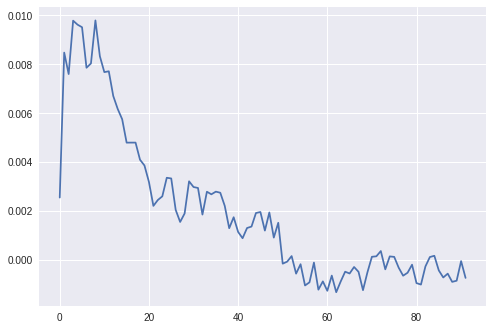

In [0]:
game_progress = [model.predict([[game[:i]]])[1][0][0]-0.5 for i in range(1, len(game), 5)]
plt.plot(range(len(game_progress)), game_progress)


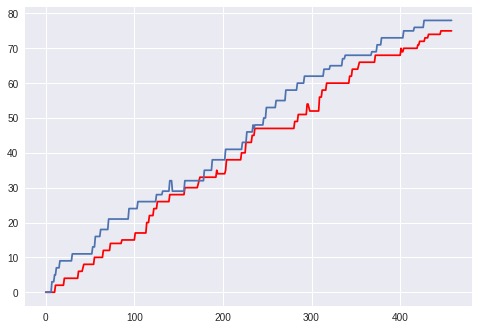

In [0]:
game_hscore = [v[1] for v in game]
game_ascore = [v[2] for v in game]
plt.plot(range(len(game_hscore)), game_hscore, c='r')
plt.plot(range(len(game_ascore)), game_ascore)

In [0]:
types = ['elapsed_time_sec', 'home_pts', 'away_pts']
event_type = {'miss': 0,'steal': 1,'assist': 2,'rebound': 3,'block': 4,'turnover': 5,'sub': 6,'foul': 7,'good': 8,'timeout': 9, 'tv_timeout': 10, 'deadball': 11, 'for': 12, 'def pts': 13}
shot_type = {'3ptr': 0, 'ft': 1, 'layup': 2, 'dunk': 3, 'jumper': 4, 'tipin': 5}
rebound_type = {'def': 0, 'off': 1, 'deadb': 2}
def convert(timeframe):
  for i in range(len(timeframe)):
    if 3 <= i < 17:
      print(list(event_type.keys())[list(event_type.values()).index(i-3)] + ": " + str(timeframe[i]))
    elif 18 <= i < 24:
      print(list(shot_type.keys())[list(shot_type.values()).index(i-18)] + ": " + str(timeframe[i]))
    elif i == 17:
      print("shot_made: " + str(timeframe[i]))
    elif 24 <= i < 27:
      print(list(rebound_type.keys())[list(rebound_type.values()).index(i-24)] + ": " + str(timeframe[i]))
    elif i == 27:
      print('technical: ' + str(timeframe[i]))

convert([128.0, 2.0, 2.0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

miss: 1
steal: 0
assist: 0
rebound: 0
block: 0
turnover: 0
sub: 0
foul: 0
good: 0
timeout: 0
tv_timeout: 0
deadball: 0
for: 0
def pts: 0
shot_made: 0
3ptr: 1
ft: 0
layup: 0
dunk: 0
jumper: 0
tipin: 0
def: 0
off: 0
deadb: 0
technical: 0


In [0]:
for i in range(1, len(game_progress)):
#   print(abs(game_progress[i] - game_progress[i-1]))
  if abs(game_progress[i] - game_progress[i-1]) > 0.001:
    print("PLAY:", i)
    print(game_progress[i-1], "->", game_progress[i])
    print(game[i])
    print(convert(game[i]))

PLAY: 1
0.0025475025177001953 -> 0.008481204509735107
[3.0, 0.0, 0.0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
miss: 1
steal: 0
assist: 0
rebound: 0
block: 0
turnover: 0
sub: 0
foul: 0
good: 0
timeout: 0
tv_timeout: 0
deadball: 0
for: 0
def pts: 0
shot_made: 0
3ptr: 1
ft: 0
layup: 0
dunk: 0
jumper: 0
tipin: 0
def: 0
off: 0
deadb: 0
technical: 0
None
PLAY: 3
0.007602274417877197 -> 0.009787976741790771
[13.0, 0.0, 0.0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
miss: 0
steal: 0
assist: 0
rebound: 1
block: 0
turnover: 0
sub: 0
foul: 0
good: 0
timeout: 0
tv_timeout: 0
deadball: 0
for: 0
def pts: 0
shot_made: 0
3ptr: 0
ft: 0
layup: 0
dunk: 0
jumper: 0
tipin: 0
def: 1
off: 0
deadb: 0
technical: 0
None
PLAY: 6
0.009519994258880615 -> 0.007860779762268066
[35.0, 0.0, 0.0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
miss: 0
steal: 0
assist: 1
rebound: 0
block: 0
turnover: 0
sub: 0
foul: 0
good: 0
t

In [0]:
client.query(f'SELECT * FROM `{bqdb}.pbp` WHERE game_id="{game_id}" ORDER BY elapsed_time_sec').to_dataframe().loc[48]

season                              2016
game_id              1004-346-2017-01-02
is_home                                1
is_neutral                             N
home_pts                               0
away_pts                               0
player_id                    1.85665e+06
player_full_name         PARNELL,DARRAJA
scheduled_date                2017-01-02
elapsed_time_sec                     309
game_clock                         14:51
period                                 1
team_code                           1004
event_type                           SUB
shot_made                          False
shot_type                           None
points_scored                          0
three_point_shot                   False
rebound_type                        None
timeout_duration                    None
foul_type                           None
substitution_type                     IN
Name: 48, dtype: object